In [1]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd # Notebook only

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management

# from google.colab import drive
# import tarfile
# from shutil import copyfile

# Frequency analysis
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow

In [113]:
sound_rate, sound_data = wav.read('C:/Users/sam/Desktop/DSP/data/recordings/recordings/0_jackson_0.wav')
# Play the signal

ipd.Audio(sound_data, rate=sound_rate)

sound_data.shape




(5148,)

## Data Loading 


In [47]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            #print("SIGNAL: ", signal)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

In [3]:
def feats_temporal(input, size=1000):
    # Remove any values exceeding the given limit
    output = input[0:min(size, input.shape[0])]
    # Add null values (padding) in order to reach the requested size
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

In [8]:
# Data loading

X_train, X_test, y_train, y_test = load_data('C:/Users/sam/Desktop/DSP/data/recordings/recordings',feature_extractor=feats_temporal, normalize=True)




In [9]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 23.361s


In [10]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.29      0.37        17
           1       0.08      0.20      0.11        10
           2       0.43      0.40      0.41        15
           3       0.11      0.05      0.07        19
           4       0.00      0.00      0.00        11
           5       0.13      0.43      0.20        14
           6       0.35      0.50      0.41        14
           7       0.00      0.00      0.00        19
           8       0.25      0.06      0.10        17
           9       0.33      0.14      0.20        14

    accuracy                           0.20       150
   macro avg       0.22      0.21      0.19       150
weighted avg       0.22      0.20      0.19       150



Confusion matrix:


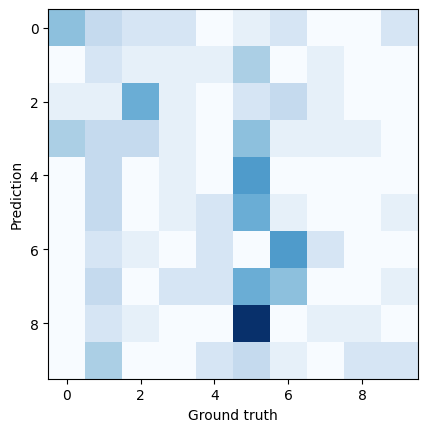

In [11]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');

### Frequency features (Fourier)

In [1722]:
def feats_fourier(input, size=1000):
    input_ft = np.real(rfft(input))
    # Remove any values exceeding the given limit
    output = input_ft[0:min(size, input_ft.shape[0])]
    # Add null values (padding) in order to reach the requested size
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

    

In [1723]:
# Data loading

X_train, X_test, y_train, y_test = load_data('C:/Users/sam/Desktop/DSP/data/recordings/recordings',feature_extractor=feats_fourier, normalize=True)




In [1724]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 22.363s


In [1725]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.06      0.08        17
           1       0.06      0.10      0.07        10
           2       0.20      0.13      0.16        15
           3       0.21      0.21      0.21        19
           4       0.11      0.18      0.13        11
           5       0.00      0.00      0.00        14
           6       0.33      0.07      0.12        14
           7       0.40      0.11      0.17        19
           8       0.00      0.00      0.00        17
           9       0.13      0.57      0.21        14

    accuracy                           0.14       150
   macro avg       0.16      0.14      0.12       150
weighted avg       0.17      0.14      0.12       150



Confusion matrix:


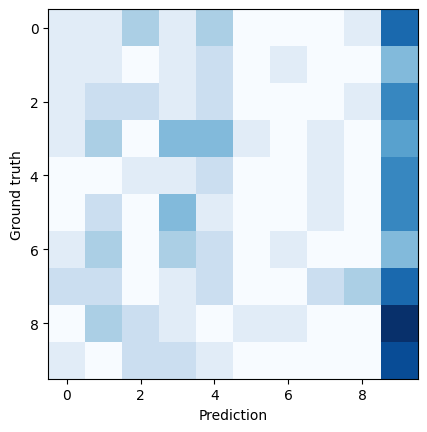

In [1726]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

# Assignment


## Frequency Feartures (Spectrogram)

In [4]:
def feats_spectrogram(input, rate=8000, tsize=14):
    #Step 1, convert the input 1D signal to a 2D spectrogram
    [spec_freqs, spec_times, spec] = spectrogram(input, fs=rate)
    #Step 2, truncate the second dimension to 14 or add zeros to get for all the data the same shape
    output = spec[:, :min(tsize, spec.shape[1])]
    output = np.hstack((output, np.zeros((spec.shape[0], tsize - output.shape[1]))))
    #Step 3, Unroll the 2-dimensional feature into a 1-dimensional vector
    output = output.flatten()
    return output


In [5]:

X_train, X_test, y_train, y_test = load_data('C:/Users/sam/Desktop/DSP/data/recordings/recordings', feature_extractor=feats_spectrogram, normalize=True)

# Verify the shape of extracted features
print(X_train[0].shape)



(1806,)


In [6]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))



Training completed in 111.155s


In [7]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.59      0.69        17
           1       0.64      0.70      0.67        10
           2       0.77      0.67      0.71        15
           3       0.83      0.53      0.65        19
           4       0.17      0.73      0.28        11
           5       0.71      0.71      0.71        14
           6       0.30      0.43      0.35        14
           7       0.67      0.32      0.43        19
           8       1.00      0.24      0.38        17
           9       0.62      0.36      0.45        14

    accuracy                           0.51       150
   macro avg       0.65      0.53      0.53       150
weighted avg       0.68      0.51      0.54       150



Confusion matrix:


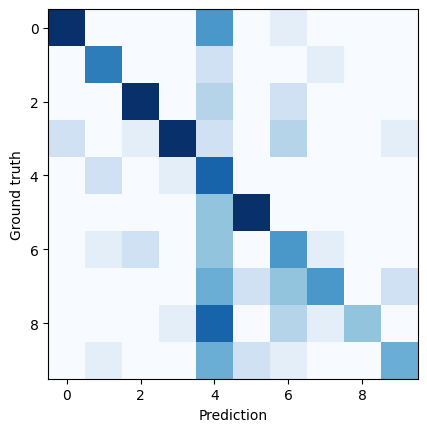

In [8]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

In [9]:
del  X_train, X_test, y_train, y_test


###  Temporal/Frequency features (Mel Spectrogram)

In [96]:
def feats_mels(input, rate=8000, tsize=10):
    # Step 1: Convert the input 1D signal to a 2D spectrogram
    mel = melspectrogram(y=input * 1.0, sr=rate)
    print("MEL DIM: ", mel.shape)
      
    # Step 2: Ensure the mel spectrogram has a consistent second dimension size
    if mel.shape[1] > tsize:
        output = mel[:, :tsize]
    else:
        output = np.pad(mel, ((0, 0), (0, tsize - mel.shape[1])), mode='constant')
    
    print("OUTPUT DIM AFTER PADDING/TRUNCATING: ", output.shape)
    
    # Step 3: Unroll the 2-dimensional feature into a 1-dimensional vector
    output = output.flatten()
    return output

In [24]:
import librosa

In [98]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('C:/Users/sam/Desktop/DSP/data/recordings/recordings/')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('C:/Users/sam/Desktop/DSP/data/recordings/recordings/' + f)
            #print("SIGNAL: ", signal)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

In [99]:

X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mels,normalize=True)


MEL DIM:  (128, 11)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 9)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 11)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 10)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 10)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 10)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 10)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 9)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 9)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 11)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 10)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 9)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 10)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 10)
OUTPUT DIM AFTER PADDING/TRUNCATI

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2033
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1963
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2007
  warnings.warn(


MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1976
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1987
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1886
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1842
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1753
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 9)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1997
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1720
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1692
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1565
  warnings.warn(


MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 12)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1737
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1760
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1890
  warnings.warn(


MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 12)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 9)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 9)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 9)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 9)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2016
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1493
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1525
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1742
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1866
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 3)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 3)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1801
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1475
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1852
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1953
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1819
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 9)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 11)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 11)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 10)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (1

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1639
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1601
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1288
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1910
  warnings.warn(


MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 3)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1854
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1807
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1704
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1896
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2042
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1640
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1547
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1516
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1609
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1455
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1713
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2023
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1915
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1931
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1793
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 9)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 9)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1579
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1817
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1876
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1958
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1560
  warnings.warn(


MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1795
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2036
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1846
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1803
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1945
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1832
  warnings.warn(


MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2039
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1873
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1632
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1806
  warnings.warn(


MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 10)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 11)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (12

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2022
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2014
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2045
  warnings.warn(


MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1790
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1705
  warnings.warn(


MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1673
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1970
  warnings.warn(


MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 17)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1722
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1850
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1843
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1778
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1433
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 3)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 3)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2012
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1911
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1569
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1973
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1434
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 3)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 3)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 3)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 3)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 3)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1357
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1968
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1593
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1913
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1149
  warnings.warn(


MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 3)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 3)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1610
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1259
  warnings.warn(


MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 10)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 9)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1978
  warnings.warn(


MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1965
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2020
  warnings.warn(


MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 10)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 9)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 9)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1998
  warnings.warn(


MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1858
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1936
  warnings.warn(


MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 8)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2015
  warnings.warn(


MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 7)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 4)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 5)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128, 10)
MEL DIM:  (128, 6)
OUTPUT DIM AFTER PADDING/TRUNCATING:  (128,

In [100]:

# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))



Training completed in 57.588s


In [101]:

# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))  ## previous results

Best parameters combination:
 C: 500
 gamma: 0.005


In [102]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))



              precision    recall  f1-score   support

           0       0.29      0.88      0.43        17
           1       0.75      0.60      0.67        10
           2       0.73      0.73      0.73        15
           3       0.86      0.63      0.73        19
           4       0.38      0.55      0.44        11
           5       0.71      0.71      0.71        14
           6       0.75      0.43      0.55        14
           7       0.82      0.47      0.60        19
           8       1.00      0.41      0.58        17
           9       0.80      0.29      0.42        14

    accuracy                           0.57       150
   macro avg       0.71      0.57      0.59       150
weighted avg       0.72      0.57      0.59       150



Confusion matrix:


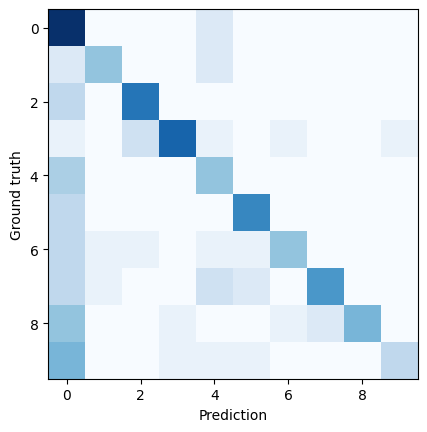

In [103]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

## Cepstral features (MFCC)

In [115]:
def extract_mfcc(input, rate=8000, tsize=10):
    mfccs = mfcc(y=input*1.0, sr=sound_rate)
    print("MFCC DIM: ", mfccs.shape)
    #Step 1, truncate the second dimension to 14 or add zeros to get for all the data the same shape
    output = mfccs[:, :min(tsize, mfccs.shape[1])]
    output = np.hstack((output, np.zeros((mfccs.shape[0], tsize - output.shape[1]))))
    #Step 2, Unroll the 2-dimensional feature into a 1-dimensional vector
    output = output.flatten()
    return output

In [116]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=extract_mfcc, normalize=True)



MFCC DIM:  (20, 11)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 12)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 13)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 10)
MFCC DIM:

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2033
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1963
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2007
  warnings.warn(


MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1976
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1987
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1886
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1842
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1753
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 12)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1997
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1720
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1692
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1565
  warnings.warn(


MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 9)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1737
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1760
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1890
  warnings.warn(


MFCC DIM:  (20, 9)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 12)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DI

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2016
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1493
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1525
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1742
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1866
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 3)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1801
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1475
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1852
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1953
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1819
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1639
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1601
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1288
  warnings.warn(


MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 3)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1910
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1854
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1807
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1704
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1896
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1640
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1547
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1516
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1609
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1455
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1713
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2023
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1915
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1931
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1793
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1579
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1817
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1876
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1958
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1560
  warnings.warn(


MFCC DIM:  (20, 5)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1795
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2036
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1846
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1803
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1945
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MFCC DIM:  (20, 4)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1832
  warnings.warn(


MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2039
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1873
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1632
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1806
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2022
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 5)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2045
  warnings.warn(


MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1790
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1705
  warnings.warn(


MFCC DIM:  (20, 8)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1673
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1970
  warnings.warn(


MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 13)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 14)
MFCC DIM:  (20, 14)
MFCC DIM:  (20, 14)
MFCC DIM:  (20, 12)
MFCC DIM:  (20, 12)
MFCC DIM:  (20, 14)
MFCC DIM:  (20, 12)
MFCC DIM:  (20, 12)
MFCC DIM:  (20, 14)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 13)
MFCC DIM:  (20, 12)
MFCC DIM:  (20, 13)
MFCC DIM:  (20, 12)
MFCC DIM:  (20, 13)
MFCC DIM:  (20, 12)
MFCC DIM:  (20, 13)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 14)
MFCC DIM:  (20, 13)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 14)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 12)
MFCC DIM:  (20, 12)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 1

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1722
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1850
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1843
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1778
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1433
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 3)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 3)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 3)
MFCC DIM:  (20, 3)
MFCC DIM:  (20, 3)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 3)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1973
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1434
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1295
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1403
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1634
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-pac

MFCC DIM:  (20, 3)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 3)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 3)
MFCC DIM:  (20, 8)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1913
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1149
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1610
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1259
  warnings.warn(


MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1978
  warnings.warn(


MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 11)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 5)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1965
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2020
  warnings.warn(


MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 35)
MFCC DIM:  (20, 13)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1998
  warnings.warn(


MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1858
  warnings.warn(
c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1936
  warnings.warn(


MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2015
  warnings.warn(


MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 4)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  (20, 9)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 6)
MFCC DIM:  (20, 10)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 5)
MFCC DIM:  (20, 7)
MFCC DIM:  (20, 8)
MFCC DIM:  

In [117]:
X_train[0].shape

(200,)

In [118]:
# Count occurrences of each class label in training set
unique_train, counts_train = np.unique(y_train, return_counts=True)
class_counts_train = dict(zip(unique_train, counts_train))

# Count occurrences of each class label in test set
unique_test, counts_test = np.unique(y_test, return_counts=True)
class_counts_test = dict(zip(unique_test, counts_test))

print("Class distribution in training set:")
print(class_counts_train)

print("\nClass distribution in test set:")
print(class_counts_test)


Class distribution in training set:
{'0': 133, '1': 140, '2': 135, '3': 131, '4': 139, '5': 136, '6': 136, '7': 131, '8': 133, '9': 136}

Class distribution in test set:
{'0': 17, '1': 10, '2': 15, '3': 19, '4': 11, '5': 14, '6': 14, '7': 19, '8': 17, '9': 14}


In [119]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], 'kernel': ['linear', 'rbf', 'poly']}

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))


Training completed in 60.696s


In [120]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       0.93      1.00      0.97        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



Confusion matrix:


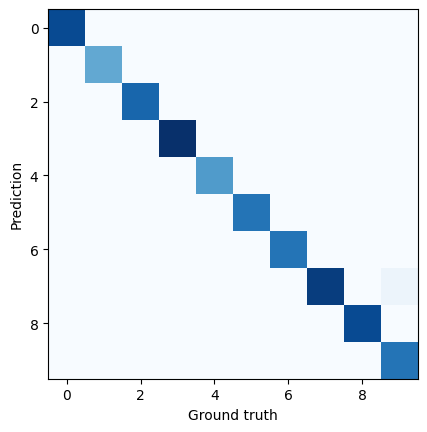

In [121]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');